In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter

plt.rcParams["font.family"] = "serif"

dataset = ["STK","TAO","HPC","EM","FC"] # will be added soon

In [3]:
def preprocessing(pathList):
    headerf = open(pathList[0]+".txt")
    header = headerf.readline()
    header = "\t".join(header.split())
    w=open("separated.csv",'w')
    w.write(header+"\n")
    for path in pathList:
        f=open(path+".txt",'r')
        i = -1
        for line in f.readlines():
            i += 1
            if (len(line.split())<9) or (i<1):
                continue
            tab_sep_line = "\t".join(line.split())
            w.write(tab_sep_line+"\n")

    w.close()
    dataframe = pd.read_csv(os.getcwd()+"/separated.csv", sep="\t")
    return dataframe   

In [4]:
df = preprocessing(dataset)
df.head()

,Dataset,Queryset,ChgQRatio,Method,Time,AvgMem,PeakMem,#Out,#OutQ
0,STK,STK_Q1,0.0,NAIVE,75.69,3.0,3.0,1235,1235
1,STK,STK_Q1,0.0,SOP,52.59,9.0,9.0,1235,1235
2,STK,STK_Q1,0.0,pMCSKY,59.03,6.0,7.0,1203,1203
3,STK,STK_Q1,0.0,OURS-Q,11.63,5.0,5.0,1235,1235
4,STK,STK_Q1,0.0,OURS-D,4.45,5.0,5.0,1235,1235


In [5]:


algo_color = {'NAIVE': 'black',
              'SOP': '#4BACC6',
              'pMCSKY': '#1F497D',
              'OURS-Q': '#F79646',
              'OURS-D': '#9BBB59',
              'OURS': '#C0504D'}

fontsize_Tick=10
fontsize_xLabel=20
fontsize_yLabel=20

algo_line = {'NAIVE': '-',
              'SOP': '-',
              'pMCSKY': '-',
              'OURS-Q': '--',
              'OURS-D': '--',
              'OURS': '-'}

basic_linewidth = 1.5
algo_linewidth = {'NAIVE': basic_linewidth,
                  'SOP': basic_linewidth,
                  'pMCSKY': basic_linewidth,
                  'OURS-Q': basic_linewidth/2,
                  'OURS-D': basic_linewidth/2,
                  'OURS': basic_linewidth}

In [21]:
dataset = ["STK","TAO","HPC","EM","FC"] # will be added soon
dataname = dataset.pop()
graphdf = df.loc[(df["Dataset"]==dataname)&(df["Queryset"].str.contains(r"\_Q100$")) & (df['ChgQRatio']==0)].pivot(index="Dataset",columns="Method",values="Time")

for dataname in dataset:
    graphdf = pd.concat([graphdf, df.loc[(df["Dataset"]==dataname)&(df["Queryset"].str.contains(r"\_Q100$")) & (df['ChgQRatio']==0)].pivot(index="Dataset",columns="Method",values="Time")])
graphdf = graphdf[algo_color.keys()]

graphdf.head()

Method      NAIVE     OURS   OURS-D  OURS-Q      SOP   pMCSKY
Dataset                                                      
FC       92440.97  1267.72  1919.78   645.1  6906.65  6488.66
Method      NAIVE     OURS   OURS-D  OURS-Q      SOP   pMCSKY
Dataset                                                      
FC       92440.97  1267.72  1919.78  645.10  6906.65  6488.66
STK      17886.19    19.89    66.03  689.32  3551.09  3454.77
Method      NAIVE     OURS   OURS-D  OURS-Q      SOP   pMCSKY
Dataset                                                      
FC       92440.97  1267.72  1919.78  645.10  6906.65  6488.66
STK      17886.19    19.89    66.03  689.32  3551.09  3454.77
TAO      11905.54    72.03   423.12  606.38  3967.52  3794.18
Method      NAIVE     OURS   OURS-D  OURS-Q      SOP   pMCSKY
Dataset                                                      
FC       92440.97  1267.72  1919.78  645.10  6906.65  6488.66
STK      17886.19    19.89    66.03  689.32  3551.09  3454.77
TAO     

Method,NAIVE,SOP,pMCSKY,OURS-Q,OURS-D,OURS
Dataset,,,,,,
FC,92440.97,6906.65,6488.66,645.10,1919.78,1267.72
STK,17886.19,3551.09,3454.77,689.32,66.03,19.89
TAO,11905.54,3967.52,3794.18,606.38,423.12,72.03
HPC,18577.20,3728.84,3374.38,411.61,6727.60,594.04
EM,28230.84,13642.48,12924.29,3524.85,9024.56,2921.49


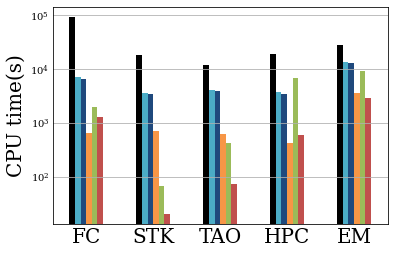

In [22]:
ax = graphdf.plot(kind='bar',color=algo_color.values())
# plt figure settings
ax.grid(b=True,which="major",axis='y')
ax.set_yscale("log")
ax.set_xlabel("")
ax.set_ylabel('CPU time(s)', fontsize=fontsize_xLabel)

# TODO: Put pattern in the bar graph

# remove ticks
ax.tick_params(axis ='both', which ='both', length = 0)
ax.tick_params(axis ='x', labelsize=fontsize_xLabel)
# rotate ticks
ax.tick_params(axis ='x', rotation = 0)
ax.get_legend().remove()
# color map for each bar

plt.savefig('asdf.pdf', bbox_inches='tight', format='pdf')
